# The Impact of Cultural Participation on National Innovation
**Abstract:** This study explores the link between cultural engagement and innovation performance across 32 European nations. By integrating Eurostat cultural data with the European Innovation Scoreboard (2022-2025), it evaluates if cultural participation meaningfully contributes to economic innovation.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

1. Data Import

In [6]:
# Eurostat cultural participation data (2022)
culture_path = "/content/ilc_scp03$dv_550_page_spreadsheet.xlsx"
# European Innovation Scoreboard data
eis_path = "/content/EIS_web_download.xlsx"

culture_raw = pd.read_excel(culture_path)
eis_raw = pd.read_excel(eis_path)

# Inspect the structure
culture_raw.head(), eis_raw.head()

(                              ACL00 (Labels)  \
 0                               GEO (Labels)   
 1  European Union - 27 countries (from 2020)   
 2                                    Belgium   
 3                                   Bulgaria   
 4                                    Czechia   
 
   Cultural activities (cinema, live performances or cultural sites)  
 0                                                NaN                 
 1                                                  :                 
 2                                               76.3                 
 3                                               38.3                 
 4                                               78.3                 ,
   iso2  country   group  year indicator_code  \
 0   AL  Albania  non-eu  2018            SII   
 1   AL  Albania  non-eu  2018          1.1.1   
 2   AL  Albania  non-eu  2018          1.1.2   
 3   AL  Albania  non-eu  2018          1.1.3   
 4   AL  Albania  non-eu  2018  

2. Cleaning cultural participation data

In [7]:
culture = culture_raw.copy()

# Standardise column names
culture.columns = culture.columns.str.lower()

# Drop useless rows
culture = culture.drop(index=[0])
culture.head()

,acl00 (labels),"cultural activities (cinema, live performances or cultural sites)"
1,European Union - 27 countries (from 2020),:
2,Belgium,76.3
3,Bulgaria,38.3
4,Czechia,78.3
5,Denmark,86.1


In [8]:
# Rename key columns (adjust if naming differs slightly)
culture = culture.rename(columns={
    "acl00 (labels)": "country",
    "cultural activities (cinema, live performances or cultural sites)": "participation_rate"
})

indices_to_drop = culture[culture["participation_rate"] == ":"].index

# Drop the identified rows
culture.drop(indices_to_drop, inplace=True)

culture["participation_rate"] = pd.to_numeric(
    culture["participation_rate"],
    errors="coerce"
)

print(culture)

        country  participation_rate
2       Belgium                76.3
3      Bulgaria                38.3
4       Czechia                78.3
5       Denmark                86.1
7       Estonia                82.7
8       Ireland                80.2
9        Greece                65.6
10        Spain                80.4
11       France                75.7
12      Croatia                69.4
13        Italy                64.0
14       Cyprus                53.7
15       Latvia                57.6
16    Lithuania                72.1
17   Luxembourg                89.0
18      Hungary                63.2
19        Malta                61.9
20  Netherlands                86.9
21      Austria                79.0
22       Poland                76.8
23     Portugal                81.2
24      Romania                41.9
25     Slovenia                72.1
26     Slovakia                61.1
27      Finland                78.9
28       Sweden                76.9
30       Norway             

3. Cleaning European Innovation Scoreboard data

In [9]:
eis = eis_raw.copy()
# Standardise column names
eis.columns = eis.columns.str.lower()

# The EIS contains many indicators, retain only the headline index
eis_sii = eis[
    eis["indicator"].str.contains("Summary Innovation Index", case=False, na=False)
]
# Pivot to obtain country–year values
eis_sii_pivot = (
    eis_sii
    .pivot_table(
        index=["country", "year"],
        values="value",
        aggfunc="mean"
    )
    .reset_index()
)
# Rename and clean
eis_sii_pivot = eis_sii_pivot.rename(
    columns={"value": "innovation_score"}
)
eis_sii_pivot["innovation_score"] = pd.to_numeric(
    eis_sii_pivot["innovation_score"], errors="coerce"
)

In [10]:
# Keep recent years (2022–2025)
eis_sii_pivot = eis_sii_pivot[
    eis_sii_pivot["year"].between(2022, 2025)
]
eis_sii_pivot.head()

,country,year,innovation_score
4,Albania,2022,40.624234
5,Albania,2023,39.239770
6,Albania,2024,38.267340
7,Albania,2025,42.658124
12,Austria,2022,128.971362


4. Merging datasets

In [11]:
# Merge cultural participation with innovation scores
data = eis_sii_pivot.merge(
    culture,
    on="country",
    how="inner"
)

# Drop missing observations
data = data.dropna(subset=["innovation_score", "participation_rate"])
print(data)

         country  year  innovation_score  participation_rate
0        Albania  2022         40.624234                48.3
1        Albania  2023         39.239770                48.3
2        Albania  2024         38.267340                48.3
3        Albania  2025         42.658124                48.3
4        Austria  2022        128.971362                79.0
..           ...   ...               ...                 ...
119       Sweden  2025        155.456410                76.9
120  Switzerland  2022        164.204927                88.9
121  Switzerland  2023        159.927355                88.9
122  Switzerland  2024        159.002637                88.9
123  Switzerland  2025        157.374400                88.9

[124 rows x 4 columns]


 5. Descriptive statistics

In [12]:
desc_stats = data[[
    "participation_rate",
    "innovation_score"
]].describe()

print(desc_stats)

       participation_rate  innovation_score
count          124.000000        124.000000
mean            70.387097        101.199885
std             14.007309         35.682858
min             38.300000         37.894093
25%             61.900000         71.582157
50%             75.700000        101.056829
75%             80.400000        132.098113
max             89.000000        164.204927


6. Exploratory visualisation

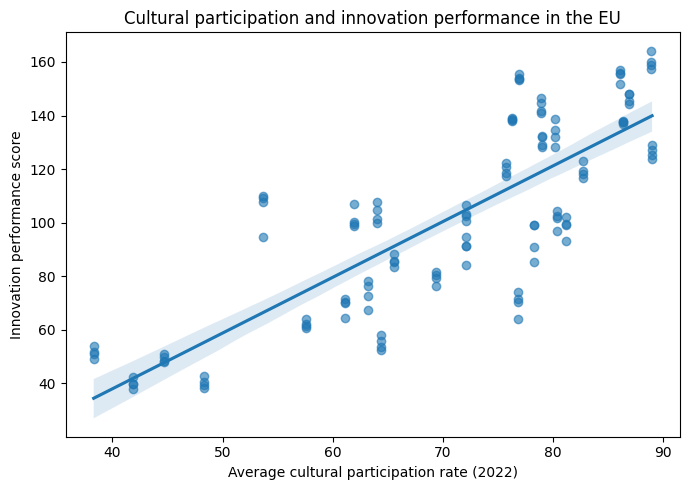

In [13]:
# Visualisation to help identify patterns
plt.figure(figsize=(7,5))
sns.regplot(
    data=data,
    x="participation_rate",
    y="innovation_score",
    scatter_kws={"alpha": 0.6}
)
plt.xlabel("Average cultural participation rate (2022)")
plt.ylabel("Innovation performance score")
plt.title("Cultural participation and innovation performance in the EU")
plt.tight_layout()
plt.show()

7. Correlation analysis

In [14]:
# Compute Pearson correlation between cultural participation and innovation performance
corr = data[["participation_rate", "innovation_score"]].corr()
print(corr)

                    participation_rate  innovation_score
participation_rate            1.000000          0.816675
innovation_score              0.816675          1.000000


8. Predective modeling

In [15]:
X = data[["participation_rate"]]
y = data["innovation_score"]

In [16]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42
)

In [17]:
# Linear Regression
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_pred_lr = linreg.predict(X_test)

print("Linear regression R²:", r2_score(y_test, y_pred_lr))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))

Linear regression R²: 0.6053605844151967
RMSE: 22.149028493794876


In [18]:
# Random Forest Regressor
rf = RandomForestRegressor(
    n_estimators=500,
    random_state=42
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

r2 = r2_score(y_test, y_pred_rf)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print("Random forest R²:", r2_score(y_test, y_pred_rf))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))

Random forest R²: 0.9202234222802241
RMSE: 9.958459308477376
